## Finetune EleutherAI/polyglot-ko-12.8b

PEFT QLORA

## Setup

Run the cells below to setup and install the required libraries. For our experiment we will need `accelerate`, `peft`, `transformers`, `datasets` and TRL to leverage the recent [`SFTTrainer`](https://huggingface.co/docs/trl/main/en/sft_trainer). We will use `bitsandbytes` to [quantize the base model into 4bit](https://huggingface.co/blog/4bit-transformers-bitsandbytes). We will also install `einops` as it is a requirement to load Falcon models.

In [1]:
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets bitsandbytes einops wandb scipy
!pip install click --upgrade
!pip install 'urllib3<2'

## Dataset

For our experiment, we will use the Guanaco dataset, which is a clean subset of the OpenAssistant dataset adapted to train general purpose chatbots.

The dataset can be found [here](https://huggingface.co/datasets/timdettmers/openassistant-guanaco)

In [2]:
import datasets
from datasets import load_dataset

dataset_name = "beomi/KoAlpaca-v1.1a"
data = load_dataset(dataset_name, split="train")

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset parquet (/home/jovyan/.cache/huggingface/datasets/beomi___parquet/beomi--KoAlpaca-v1.1a-1465f66eb846fd61/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


## Loading the model

In this section we will load the [Falcon 7B model](https://huggingface.co/tiiuae/falcon-7b), quantize it in 4bit and attach LoRA adapters on it. Let's get started!

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoTokenizer

model_name = "EleutherAI/polyglot-ko-12.8b"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True
)
model.config.use_cache = False


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /opt/conda/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...


/opt/conda/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib64'), PosixPath('/usr/local/nvidia/lib')}
  warn(msg)
/opt/conda/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/opt/conda/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('tcp'), PosixPath('//10.152.183.150'), PosixPath('8888')}
  warn(msg)
/opt/conda/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('tcp'), PosixPath('//10.152.18

Let's also load the tokenizer below

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

Below we will load the configuration file in order to create the LoRA model. According to QLoRA paper, it is important to consider all linear layers in the transformer block for maximum performance. Therefore we will add `dense`, `dense_h_to_4_h` and `dense_4h_to_h` layers in the target modules in addition to the mixed query key value layer.

In [5]:
from peft import LoraConfig

lora_alpha = 16
lora_dropout = 0.1
lora_r = 64

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        "query_key_value",
        "dense",
        "dense_h_to_4h",
        "dense_4h_to_h",
    ]
)

## Loading the trainer

Here we will use the [`SFTTrainer` from TRL library](https://huggingface.co/docs/trl/main/en/sft_trainer) that gives a wrapper around transformers `Trainer` to easily fine-tune models on instruction based datasets using PEFT adapters. Let's first load the training arguments below.

In [6]:
from transformers import TrainingArguments

output_dir = "./polygolt_result"
per_device_train_batch_size = 4
gradient_accumulation_steps = 4
optim = "paged_adamw_32bit"
save_steps = 100
logging_steps = 10
learning_rate = 2e-4
max_grad_norm = 0.3
max_steps = 500
warmup_ratio = 0.03
lr_scheduler_type = "constant"

training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=True,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
)

Then finally pass everthing to the trainer

In [7]:
from trl import SFTTrainer
import transformers
import os

max_seq_length = 128

trainer = SFTTrainer(
    model=model,
    train_dataset=data,
    peft_config=peft_config,
    dataset_text_field="output",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
)

/opt/conda/lib/python3.10/site-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


We will also pre-process the model by upcasting the layer norms in float 32 for more stable training

In [8]:
for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

## Train the model

Now let's train the model! Simply call `trainer.train()`

In [9]:
trainer.train()

wandb: Currently logged in as: dev7halo. Use `wandb login --relogin` to force relogin


You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
10,2.343100
20,2.210600
30,2.171500
40,2.180600
50,2.160100
60,2.118000
70,2.156500
80,2.147900
90,2.113600
100,2.055300


TrainOutput(global_step=500, training_loss=2.0877911758422854, metrics={'train_runtime': 1314.4544, 'train_samples_per_second': 6.086, 'train_steps_per_second': 0.38, 'total_flos': 4.090585153536e+16, 'train_loss': 2.0877911758422854, 'epoch': 0.5})

During training, the model should converge nicely as follows:

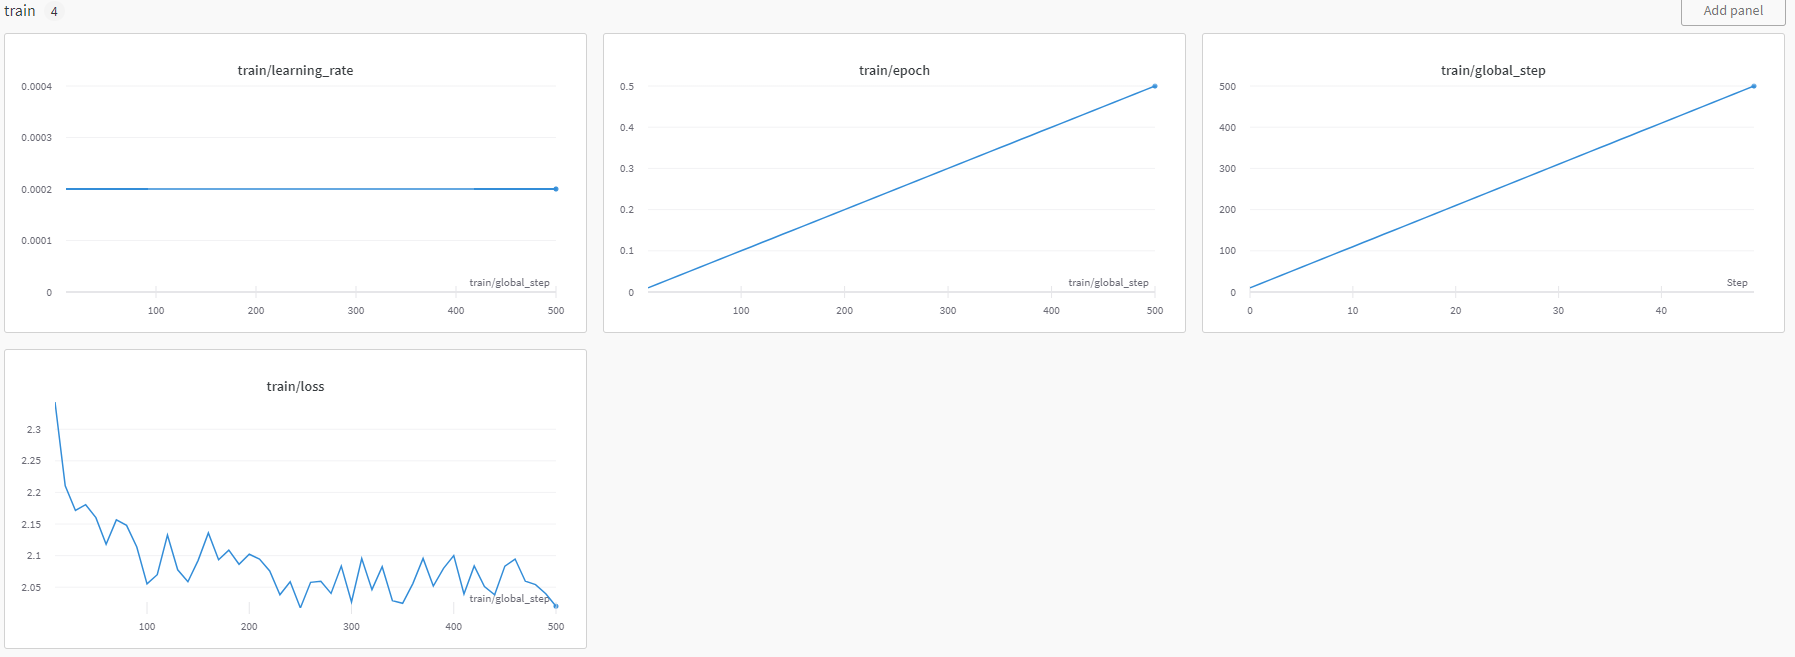

The `SFTTrainer` also takes care of properly saving only the adapters during training instead of saving the entire model.

In [11]:
def gen(x):
    q = f"### 질문: {x}\n\n### 답변:"
    # print(q)
    gened = model.generate(
        **tokenizer(
            q,
            return_tensors='pt',
            return_token_type_ids=False
        ).to('cuda'),
        max_new_tokens=50,
        early_stopping=True,
        do_sample=True,
        eos_token_id=2,
    )
    print(tokenizer.decode(gened[0]))

In [12]:
gen('건강하게 살기 위한 세 가지 방법은?')

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1259: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


### 질문: 건강하게 살기 위한 세 가지 방법은?

### 답변: 첫째, 적당한 운동을 합시다. 둘째, 항상 긍정적인 마음을 갖는 것이 중요합니다. 셋째, 몸에 좋은 음식을 골고루 섭취하세요. 다만, 지방과 탄수화물은 피해야 합니다.
###
